# Data Reading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from backtesting import Strategy
from backtesting import Backtest
from sklearn.linear_model import LogisticRegression


In [2]:
df_ohlc=pd.read_csv('data/BinanceTop10Raw.csv',header=[0, 1],index_col=0)
df_ohlc.index=pd.DatetimeIndex(df_ohlc.index)
df_Close=df_ohlc.swaplevel(axis=1)['Close']
instruments=df_ohlc.columns.get_level_values(0).unique()


Splitting the data


In [3]:
df_train,df_validate,df_test=df_ohlc.loc[:'2022-01-01'],df_ohlc.loc['2022-01-01':'2022-09-01'],df_ohlc.loc['2022-09-01':]

# Predicting Market Movements with Machine Learning

## LogisticRegression

In [4]:
from sklearn.linear_model import LogisticRegression
LR_trained=pd.DataFrame()
LR_test=pd.DataFrame()

In [5]:
def log_return(data):
    return np.log(data/data.shift()).fillna(0)
def get_clean_Xy(df):
    return df.iloc[1:], np.sign(log_return(df.Close).iloc[1:])


In [6]:
class LogesticMLStrategy(Strategy):
    TrainOn=None
    solver='lbfgs'
    penalty='l2'
    c=7
    n_wait=3
    price_delta = .08
    def init(self):        
        self.lm=LogisticRegression(C=np.exp(self.c*np.log(10)), solver=self.solver)

        if self.TrainOn is None:
            self.TrainOn=self.data.df.drop(columns='Volume')
        # Train the classifier in advance
        X, y = get_clean_Xy(self.TrainOn)
        self.lm.fit(X,y)

        # Plot y for inspection
        self.I(lambda: np.sign(log_return(self.data.df.Close)), name='y_true')
        # Prepare empty, all-NaN forecast indicator
        self.forecasts = self.I(lambda: np.repeat(np.nan, len(self.data)), name='forecast')
        
    def next(self):

        # Forecast the next movement
        X=self.data.df.iloc[-1:].fillna(0).drop(columns='Volume')
        forecast = self.lm.predict(X)[-1]

        # Update the plotted "forecast" indicator
        self.forecasts[-1] = forecast
        # Defining TP and SL values
        upper, lower = self.data.Close[-1] * (1 + np.r_[1, -1]*self.price_delta)

        if  sum(self.forecasts[-self.n_wait:])>1 and not self.position.is_long:
            self.buy(tp=upper, sl=lower)
        elif sum(self.forecasts[-self.n_wait:])<-1 and not self.position.is_short:
            self.sell(tp=lower, sl=upper)

        # Additionally, set aggressive stop-loss on trades that have been open 
        # for more than two days
        current_time = self.data.index[-1]
        for trade in self.trades:
            if current_time - trade.entry_time > pd.Timedelta('1 days'):
                if trade.is_long:
                    trade.sl = max(trade.sl, self.data.Low[-1])
                else:
                    trade.sl = min(trade.sl, self.data.High[-1])


In [7]:
def Metric_to_optimse(series):
    return series['Sharpe Ratio']

In [8]:
parameters={}
for instrument in instruments:
    data = df_train[instrument]
    bt_Train = Backtest(data, LogesticMLStrategy , cash=1000000)
    stats_Train = bt_Train.optimize(
        n_wait=(1,5,1),
        price_delta=(0,1,0.01),
        # c = (7,10,1),
        maximize=Metric_to_optimse,
        method='skopt',
    )
    LR_trained[instrument]=stats_Train._equity_curve.Equity/1000000
    params={'c':stats_Train._strategy.c,'solver':stats_Train._strategy.solver}
    parameters[instrument]=params


c:\Users\amine\OneDrive\Documents\GitHub\DataSience\portofolio_optimizer\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\amine\OneDrive\Documents\GitHub\DataSience\portofolio_optimizer\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative

In [9]:
for instrument in instruments:
    bt=Backtest(df_validate[instrument], LogesticMLStrategy , cash=1000000)
    stats=bt.run(TrainOn=df_train[instrument],**parameters[instrument])
    LR_test[instrument]=stats._equity_curve.Equity/1000000
    print(instrument)
    bt.plot()
    

c:\Users\amine\OneDrive\Documents\GitHub\DataSience\portofolio_optimizer\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


BTCUSDT


c:\Users\amine\OneDrive\Documents\GitHub\DataSience\portofolio_optimizer\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ETHUSDT


c:\Users\amine\OneDrive\Documents\GitHub\DataSience\portofolio_optimizer\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


BNBUSDT


c:\Users\amine\OneDrive\Documents\GitHub\DataSience\portofolio_optimizer\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


BUSDUSDT


c:\Users\amine\OneDrive\Documents\GitHub\DataSience\portofolio_optimizer\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


XRPUSDT


c:\Users\amine\OneDrive\Documents\GitHub\DataSience\portofolio_optimizer\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DOGEUSDT


c:\Users\amine\OneDrive\Documents\GitHub\DataSience\portofolio_optimizer\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ADAUSDT


c:\Users\amine\OneDrive\Documents\GitHub\DataSience\portofolio_optimizer\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


MATICUSDT


c:\Users\amine\OneDrive\Documents\GitHub\DataSience\portofolio_optimizer\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DOTUSDT


c:\Users\amine\OneDrive\Documents\GitHub\DataSience\portofolio_optimizer\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LTCUSDT


<AxesSubplot: xlabel='Open Time'>

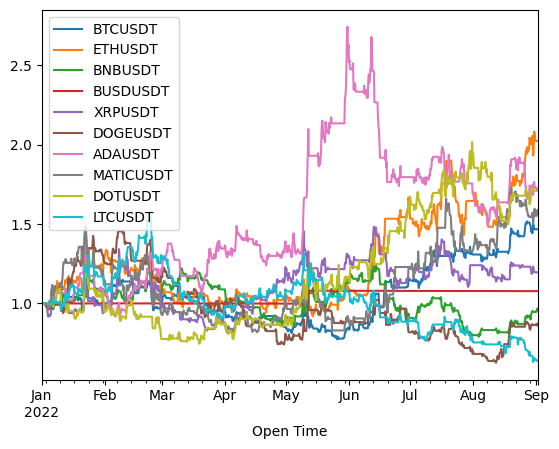

In [10]:
LR_test.plot()

In [12]:
LR_test.iloc[-1].mean()

1.3259550248963596

In [13]:
LR_trained.to_csv('ModelsResult/OptimizedLR_trained.csv')
LR_test.to_csv('ModelsResult/OptimizedLR_test.csv')
parameters

{'BTCUSDT': {'c': 7, 'solver': 'lbfgs'},
 'ETHUSDT': {'c': 7, 'solver': 'lbfgs'},
 'BNBUSDT': {'c': 7, 'solver': 'lbfgs'},
 'BUSDUSDT': {'c': 7, 'solver': 'lbfgs'},
 'XRPUSDT': {'c': 7, 'solver': 'lbfgs'},
 'DOGEUSDT': {'c': 7, 'solver': 'lbfgs'},
 'ADAUSDT': {'c': 7, 'solver': 'lbfgs'},
 'MATICUSDT': {'c': 7, 'solver': 'lbfgs'},
 'DOTUSDT': {'c': 7, 'solver': 'lbfgs'},
 'LTCUSDT': {'c': 7, 'solver': 'lbfgs'}}